## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

## Project Write-up

### Code Description
The main algorithm can be found in RunPulseRateAlgorithm function. Steps of the algorithms can be divided as follows.
1. Load ppg, accx, accy, accz signals using LoadTroikaDataFile
2. Segment each signal into windows (8 seconds per windows with 2 second sliding) and apply BandpassFilter (40-240 bpm) <br>

For each window, ....
3. Apply furior transform to each signal 
4. Normalise 'accx', 'accy' and 'accz' with their max values
5.  **Combine all normalised frequency magnitudes of 'accx', 'accy' and 'accz' by summing them togethers as acc_maxsum (summation of all acc freq magnitude that are normalised by max values)   
6.  Smooth acc_maxsum and the ppg frequency magnitude and normalised by their max values again 
7. Minus ppg frequency magnitude by acc_maxsum magnitude as PPG_minus_acc 
8. Find the PPG_minus_acc frequency that has the highest magnitude add estimate heart rate by this frequency.
9. Calculate confidence by the fraction of estimated HR frequency smoothed magnitude and the summation of all magnitudes. <br>

** The idea of combinding normalised acc magnitude is from investigating spectogram 


### Data Description
#### What activities were performed in the dataset. <br>
1. Segmentaion
2. Banpass Filter
3. fourier transform

#### Features of the sensor that was used. <br>
1. feature_sig = fft(ppg) - (fft(acc_x)/max(fft(acc_x)) + fft(acc_y)/max(fft(acc_y)) + fft(acc_z)/max(fft(acc_y)))
2. estimated hr freq = feature_sig[argmax(feature_sig)]

#### The quantity of data in the dataset. <br>
PPG signal is interfered with movement signal so we need to remove these movement noises using info from the acc signals.

#### Short-comings of the dataset. <br>
There are only few data so we cannot create very complex model due to the over-fitting issue.

### Algorithm Description
#### How the algorithm works, including a description of the physiology. <br>
Algorithms receives acc signal that mesure the acc in x,y, and z direnctions as well as PPG signal that is high at diastolic phase abd low at systolic phase due to the mechanism of light absorbsion by blood. Then the algorithm apply fft to each signal to get the frequency magnitude of acc and PPG. In order to remove the movement artifact from form the PPG signal, the algorithm minus the PPF freq magnitude by preprocessed acc freq magnitude. Finally, the estimated HR can be found by ginding the maximum magnitude of that ppg manitude. 


#### An intuitive explanation of why the confidence algorithm produces a higher number for better estimates. <br>
Based on the algorithm used in this project, HR estimation freq that has high and densed magnitude around it will give high confidence. The reason is because the dominant magnitude is likely from the dominant sorces such as heart rhythms.   


#### Insightful caveats and failure-modes of the algorithm. <br>
There is some failure cases due to indistinguishable info based on this algorithm. To improve the performance, the acc info may need to combined more wisely rather than just normalised by max values and summed up.


### Algorithm Performance
#### The algorithm performance and how it was computed. <br>
The mean absolute error at 90% availability as seen in AggregateErrorMetric function

#### Generalizability to other datasets. <br>
To improve the generalizability, the acc info may need to combined more wisely rather than just normalised by max values and summed up. Also, more data should be added to see if the algorithm can also work well with other data.

### Code

In [59]:
import matplotlib.pyplot as plt
import glob
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import os

def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def segment_signal(signal, fs = 125, window_length_s = 8, window_shift_s = 2):
    window_length = window_length_s * fs
    window_shift = window_shift_s * fs
    idx = list(range(0, len(signal) - window_length, window_shift))
    return([BandpassFilter(signal[i: i + window_length]) for i in idx])
    
def RunPulseRateAlgorithm(data_fl, ref_fl):
    # (1) Load ppg, accx, accy, accz signals using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    signals = dict(zip(['ppg', 'accx', 'accy', 'accz'], LoadTroikaDataFile(data_fl)))
    
        
    # (2) Segment each signal into windows (8 seconds per windows with 2 second sliding) and apply BandpassFilter (40-240 bpm)
    for sigtype in ['ppg', 'accx', 'accy', 'accz']:
        signals[sigtype] = segment_signal(signals[sigtype])
    signals = [{sigtype:signals[sigtype][i] for sigtype in ['ppg', 'accx', 'accy', 'accz']}  for i in range(len(signals['ppg']))]
    
    # (3) Apply furior transform to each signal
    fft_signals = [{k: fft_func(v, fs = 125) for k,v in  signal.items()} for signal in signals]
    
    
    # For each window,
    for fftsig in fft_signals:
        fftsig['acc_maxsum'] = {}
        fftsig['acc_maxsum']['freqs'] = fftsig['accx']['freqs']
        
        # (4) Normalise 'accx', 'accy' and 'accz' with their max values
        for sigtype in ['accx', 'accy', 'accz']:
            fftsig[sigtype]['fft_mag'] = 1.0*fftsig[sigtype]['fft_mag']/fftsig[sigtype]['fft_mag'].max() 
            
        # (5) Combine normalised fft of 'accx', 'accy' and 'accz' by summing them togethers as acc_maxsum (summation of all acc freq magnitude that are normalised by max values)   
        fftsig['acc_maxsum']['fft_mag'] = fftsig['accx']['fft_mag'] + fftsig['accy']['fft_mag'] + fftsig['accz']['fft_mag']
        for sigtype in ['accx', 'accy', 'accz']:
            del fftsig[sigtype]
        
        # (6) Smooth acc_maxsum and the ppg frequency magnitude and normalised by their max values again 
        for sigtype in ['ppg', 'acc_maxsum']:   
            fftsig[sigtype]['fft_mag'] = np.convolve(fftsig[sigtype]['fft_mag'], [0.0357141 ,  0.24107134,  0.44642914,  
                                                                       0.24107134,  0.0357141 ], 'same')      
            fftsig[sigtype]['fft_mag'] = fftsig[sigtype]['fft_mag']/fftsig[sigtype]['fft_mag'].max()
    
    
    ref_HR = sp.io.loadmat(ref_fl)['BPM0'].flatten() 
    errors = []
    confidence = []
    for i, signal in enumerate(fft_signals):
        # (7) Minus ppg frequency magnitude by acc_maxsum magnitude as PPG_minus_acc 
        sig =  signal['ppg']['fft_mag'] - signal['acc_maxsum']['fft_mag']
        
        # (8) Find the PPG_minus_acc frequency that has the highest magnitude add estimate heart rate by this frequency.  
        maxind = np.argmax(sig)
        errors.append(abs(signal['ppg']['freqs'][maxind]*60 - ref_HR[i]))
        
        # (9) Calculate confidence by the fraction of estimated HR frequency smoothed magnitude and the summation of all magnitudes.
        confidence.append(signal['ppg']['fft_mag'][maxind]/sum( signal['ppg']['fft_mag']))
  
    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    return errors, confidence


def BandpassFilter(signal, fs=125):
    """
    Bandpass filter the signal between 40 and 240 BPM.
    """
    b, a = sp.signal.butter(3, (40/60.0, 240/60.0), btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)

def fft_func(sig, fs):
    siglen = max(len(sig), 4096)
    freqs = np.fft.rfftfreq(siglen, 1/fs)
    fft_mag = np.abs(np.fft.rfft(sig, siglen))
    return  {'freqs': freqs, 'fft_mag': fft_mag}

In [60]:
Evaluate()

7.1738843061376363

# Use plt.specgram to visualize your signals in the frequency domain

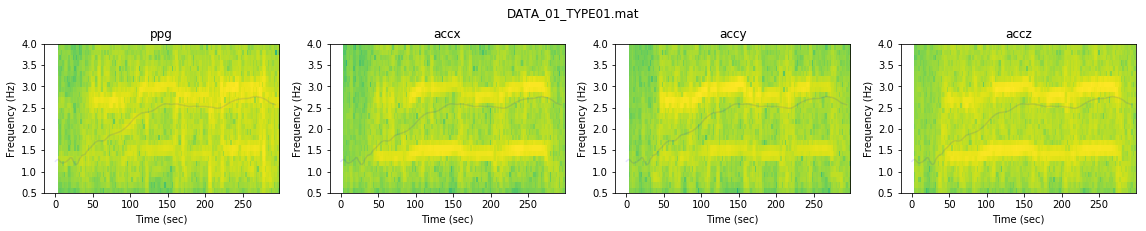

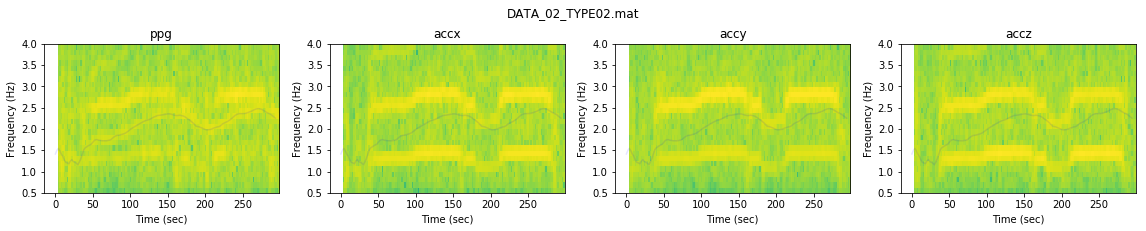

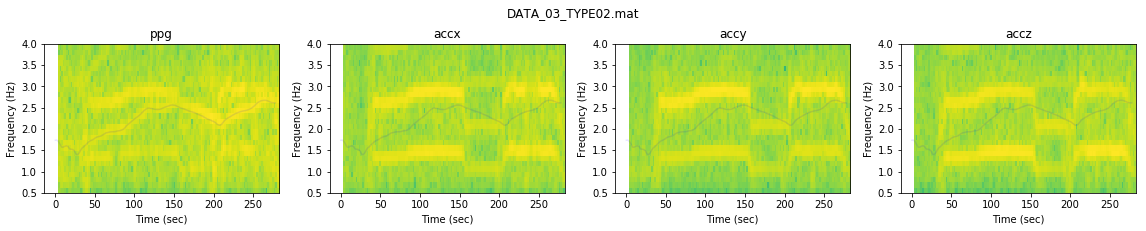

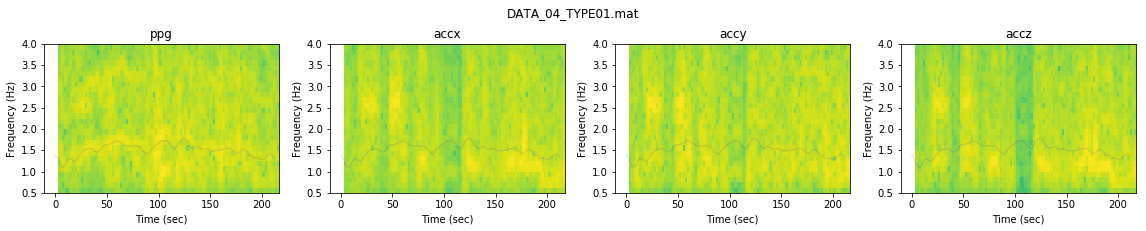

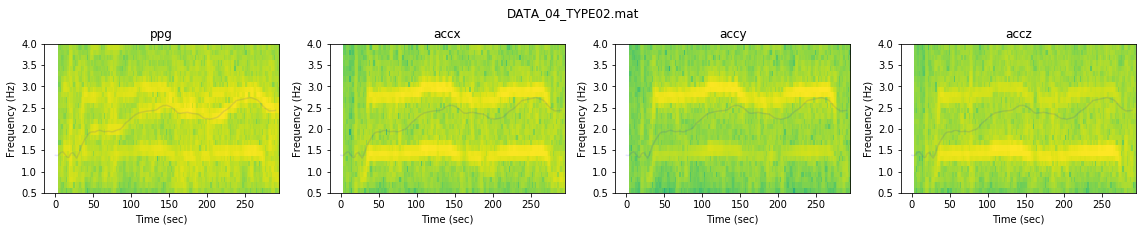

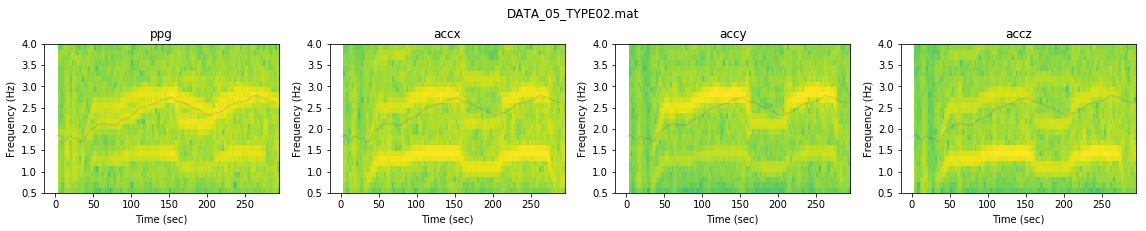

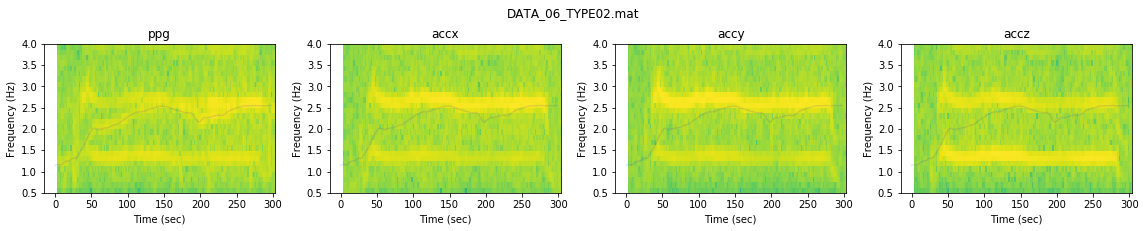

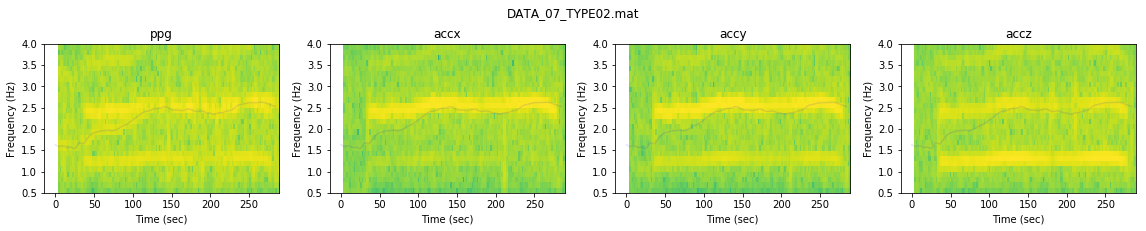

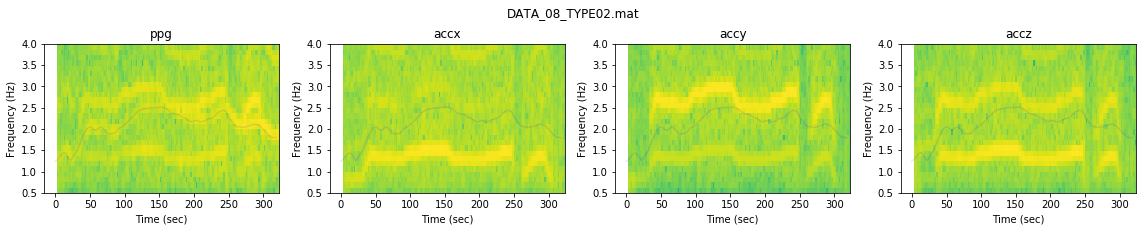

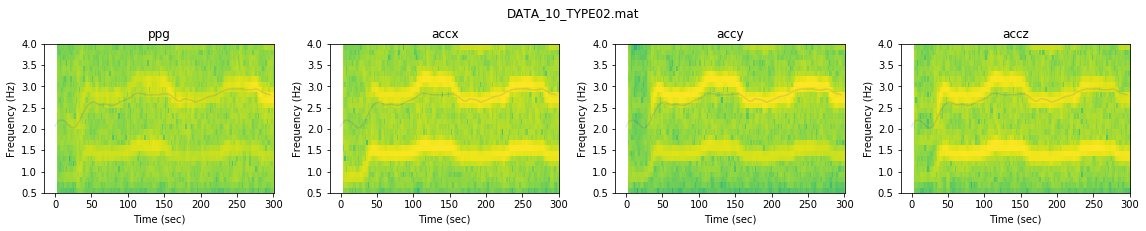

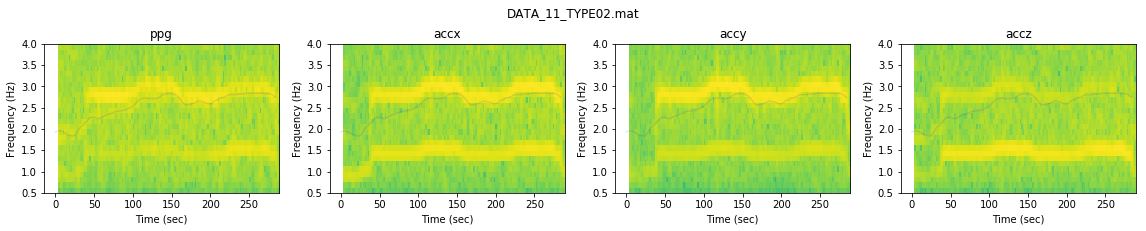

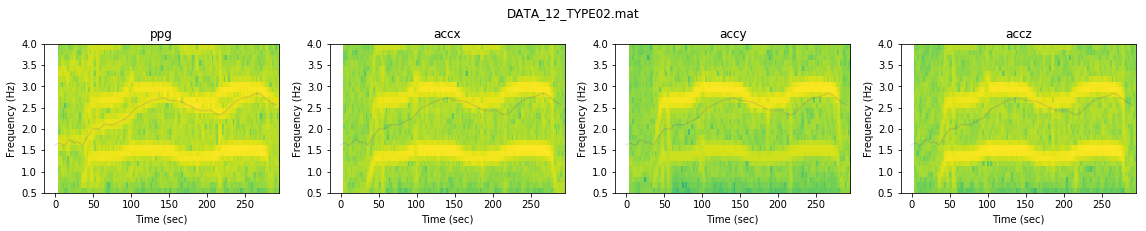

In [206]:
import matplotlib.pyplot as plt
import os


# freq indo
fs = 125
window_length_s = 8
window_shift_s = 2
window_length = window_length_s * fs
window_shift = window_shift_s * fs

# plot all specgram
data_fls, ref_fls = LoadTroikaDataset()
numcol = 4
for datafl, reffl in zip(data_fls, ref_fls):
    fig, axes = plt.subplots(1, numcol, figsize = (16, 3))
    signals = zip(['ppg', 'accx', 'accy', 'accz'], 
                 [BandpassFilter(i) for i in LoadTroikaDataFile(datafl)])
    #signals['accm'] = np.sqrt(np.sum(np.square(np.vstack((signals['accx'], signals['accy'], signals['accz']))), axis=0) 
    ref_freq = sp.io.loadmat(reffl)['BPM0'].flatten()/60.0
    ref_time = np.arange(len(ref_freq))*window_shift_s
    for j, (sigtype, sigdata) in enumerate(signals):
        axes[j].set_title(sigtype)
        axes[j].specgram(sigdata, Fs = fs, NFFT = window_length, noverlap = window_length - window_shift)
        axes[j].plot(ref_time, ref_freq,  'b', alpha = 0.1) # plot reference HRs on graph      
        axes[j].set_ylim((0.5, 4))
        axes[j].set_xlabel('Time (sec)')
        axes[j].set_ylabel('Frequency (Hz)')
    fig.tight_layout(pad = 1)
    plt.suptitle(os.path.split(datafl)[1], fontsize = 12, y = 1.05)
    plt.show()

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 